In [199]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import os
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

In [2]:
os.chdir('Data2/')

# LASSO Model

In [108]:
df = pd.read_pickle('Cleaned_Modeled_Data')

In [109]:
X = df[['Eatery', 'Lam_Total_Beer_Ratings', 'Lam_Total_Beer_Reviews', 
        'Lam_Num_Brewery_Ratings', 'Lam_Num_Brewery_Ratings', 
        'Num_Beers', 'Max_Beer_Score', 'Max_Mean_Beer_Score', 
        'Mean_Beer_Score','Lam_Brew_Rats_Revs','Lam_Beer_Rats_Revs',
        'Max_Times_Mean_Beer_Score','Count_IPA_Pale_Ale','Wild_Sour']]
y = df['Brewery_Score']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [110]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.values)
X_val = scaler.fit_transform(X_val.values)
X_test = scaler.transform(X_test.values)

In [231]:
param_grid = {
    'alpha': [.00036, .00038, .0004, .00042, .00044, .00046,],
    'max_iter': [100, 90, 80, 70, 60, 50, 40]
}
lasso = Lasso()
grid = GridSearchCV(lasso, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

grid.best_params_

{'alpha': 0.00044, 'max_iter': 60}

In [232]:
lasso_model = Lasso(alpha = .00044, max_iter = 60)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.00044, copy_X=True, fit_intercept=True, max_iter=60,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [233]:
list(zip(list(X.columns), lasso_model.coef_))

[('Eatery', -0.05619690450642595),
 ('Lam_Total_Beer_Ratings', -0.07252779783801558),
 ('Lam_Total_Beer_Reviews', -0.055860207993866574),
 ('Lam_Num_Brewery_Ratings', 0.006196654178692287),
 ('Lam_Num_Brewery_Ratings', 1.3583479094108768e-18),
 ('Num_Beers', 0.023431197088080818),
 ('Max_Beer_Score', 0.08747277539543269),
 ('Max_Mean_Beer_Score', 0.03885291314032677),
 ('Mean_Beer_Score', 0.01930481033288763),
 ('Lam_Brew_Rats_Revs', 0.0820887801797685),
 ('Lam_Beer_Rats_Revs', 3.712817619056395e-18),
 ('Max_Times_Mean_Beer_Score', 0.0005784424657490673),
 ('Count_IPA_Pale_Ale', 0.008776572851460081),
 ('Wild_Sour', 0.01991777579112055)]

In [234]:
lm_train

0.2203616513916663

In [235]:
lm_train = lasso_model.score(X_train,y_train)
lm_val = lasso_model.score(X_val,y_val)

# Print out the R^2 for the model against the full dataset
print(lm_train)
print(lm_val)
print(1 - (1-lm_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print(1 - (1-lm_val)*(len(y_val)-1)/(len(y_val)-X_test.shape[1]-1))

0.22027621703670552
0.20918049601005784
0.21579688467663727
0.1953928583315283


In [139]:
predictions = lasso_model.predict(X_test)

In [140]:
print(sqrt(mean_squared_error(y_test, predictions)))

0.30068975600833797


In [141]:
y_test.std()

0.33829027451012084

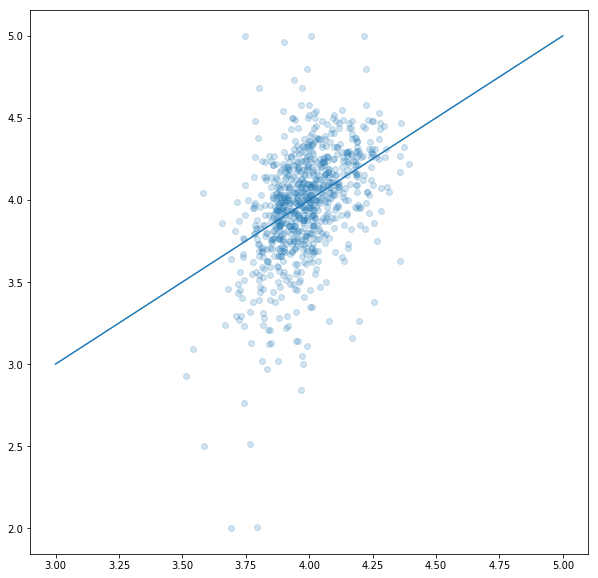

In [142]:
plt.figure(figsize=(10,10))
plt.scatter(predictions,y_test,alpha=.2)
plt.plot([3,5],[3,5])

# Ridge Test

In [236]:
df = pd.read_pickle('All_Data')

In [237]:
df['Max_Beer_Score'] = df.Max_Beer_Score.replace(0,np.nan)
df['Mean_Beer_Score'] = df.Mean_Beer_Score.replace(0,np.nan)
df['Num_Beers'] = df.Num_Beers.replace(0,np.nan)
df['Total_Beer_Reviews'] = df.Total_Beer_Reviews.replace(0,np.nan)
df['Total_Beer_Ratings'] = df.Total_Beer_Ratings.replace(0,np.nan)
df['Num_Brewery_Reviews'] = df.Total_Beer_Reviews.replace(0,np.nan)
df['Num_Brewery_Ratings'] = df.Total_Beer_Ratings.replace(0,np.nan)

In [238]:
df.dropna(inplace=True)

In [239]:
df = df[df.Total_Beer_Reviews < 300]

In [240]:
lamb1=stats.boxcox_normmax(df.Total_Beer_Ratings, brack=(-1.9, 1.9)) 
lamb2=stats.boxcox_normmax(df.Total_Beer_Reviews, brack=(-1.9, 1.9))
lamb3=stats.boxcox_normmax(df.Num_Brewery_Ratings, brack=(-1.9, 1.9))
lamb4=stats.boxcox_normmax(df.Num_Brewery_Reviews, brack=(-1.9, 1.9))

In [241]:
df['Lam_Total_Beer_Ratings'] = (np.power(df.Total_Beer_Ratings,lamb1)-1)/lamb1
df['Lam_Total_Beer_Reviews'] = (np.power(df.Total_Beer_Reviews,lamb2)-1)/lamb2
df['Lam_Num_Brewery_Ratings'] = (np.power(df.Num_Brewery_Ratings,lamb3)-1)/lamb3
df['Lam_Num_Brewery_Reviews'] = (np.power(df.Num_Brewery_Reviews,lamb4)-1)/lamb4

df['Wild_Sour'] = df.Mean_Wild_Sour * df.Max_Wild_Sour
df['Lam_Brew_Rats_Revs'] = df['Lam_Num_Brewery_Ratings'] * df['Lam_Num_Brewery_Reviews']
df['Lam_Beer_Rats_Revs'] = df['Lam_Total_Beer_Ratings'] * df['Lam_Total_Beer_Reviews']
df['Max_Times_Mean_Beer_Score'] = df['Max_Beer_Score'] * df['Max_Mean_Beer_Score'] * df['Mean_Beer_Score']

In [22]:
X = df[['Eatery', 'Lam_Total_Beer_Ratings', 'Lam_Total_Beer_Reviews', 
        'Lam_Num_Brewery_Ratings', 'Lam_Num_Brewery_Ratings', 
        'Num_Beers', 'Max_Beer_Score', 'Max_Mean_Beer_Score', 
        'Mean_Beer_Score','Lam_Brew_Rats_Revs','Lam_Beer_Rats_Revs',
        'Max_Times_Mean_Beer_Score','Count_IPA_Pale_Ale','Wild_Sour']]
y = df['Brewery_Score']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [23]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.values)
X_val = scaler.fit_transform(X_val.values)
X_test = scaler.transform(X_test.values)

In [275]:
param_grid = {
    'alpha': [32,34,36,38,40]
}
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

grid.best_params_

{'alpha': 38}

In [276]:
lr_model_ridge = Ridge(alpha = 38, max_iter = 10)
lr_model_ridge.fit(X_train, y_train)

list(zip(X.columns, lr_model_ridge.coef_))

[('Eatery', -0.05588664560603177),
 ('Lam_Total_Beer_Ratings', -0.02032639550427735),
 ('Lam_Total_Beer_Reviews', -0.04895904169532558),
 ('Lam_Num_Brewery_Ratings', -0.020326395504277995),
 ('Lam_Num_Brewery_Ratings', -0.02032639550427783),
 ('Num_Beers', 0.021370962744271547),
 ('Max_Beer_Score', 0.07888513029366173),
 ('Max_Mean_Beer_Score', 0.036582458098680964),
 ('Mean_Beer_Score', 0.00325595808083826),
 ('Lam_Brew_Rats_Revs', 0.035477854117758736),
 ('Lam_Beer_Rats_Revs', 0.035477854117758736),
 ('Max_Times_Mean_Beer_Score', 0.020553997421492377),
 ('Count_IPA_Pale_Ale', 0.01109673381009071),
 ('Wild_Sour', 0.020343248098199616)]

In [277]:
ridge_train = lr_model_ridge.score(X_train,y_train)
ridge_val = lr_model_ridge.score(X_val,y_val)

print(ridge_train)
print(ridge_val)
print(1 - (1-ridge_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print(1 - (1-ridge_val)*(len(y_val)-1)/(len(y_val)-X_test.shape[1]-1))

0.22006639054732569
0.21233827812417627
0.2155858527827227
0.1986056951773998


In [90]:
predictions = lr_model_ridge.predict(X_test)

In [91]:
print(sqrt(mean_squared_error(y_test, predictions)))

0.35903901536771454


In [86]:
y_test.std()

0.37713443321690965

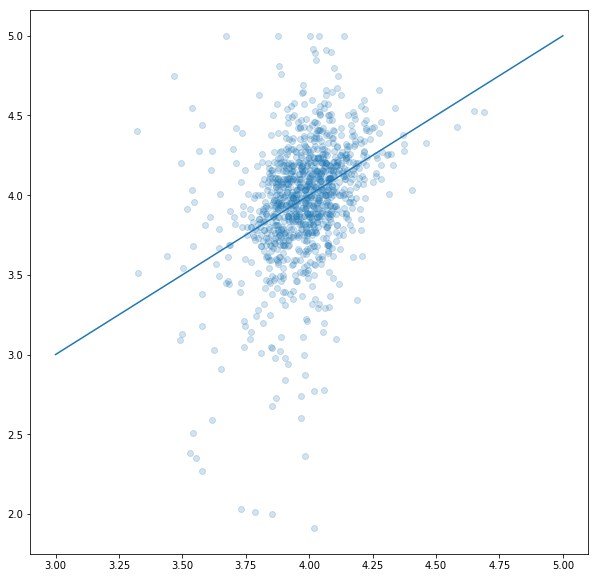

In [87]:
plt.figure(figsize=(10,10))
plt.scatter(predictions,y_test,alpha=.2)
plt.plot([3,5],[3,5])